In [3]:
import sys
import os
sys.path.append(os.path.abspath("C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code"))
import hdf5storage
import mat73
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math



import CURBD.curbd as curbd
import PyalData.pyaldata as pyaldata

to add: save 10d-pca of currents for bayes classifiers to type, save weights for plot of distribution and inh/exc currents

In [4]:
data_dir_WTM350 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2" 
data_dir_WTM355 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2" 
data_dir_ASM351 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2" 
data_dir_ASM354 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2" 
data_dir_PSM365 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2" 
data_dir_PSM366 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2" 

In [7]:
# consider all models, and no thalamus: 

# Used to get the 10D-PCA of currents for the naive Bayes Classifier:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

class_indices = {'WT-M350':1,
                'WT-M355':1, 
                'AS-M351':2,
                'AS-M354':2,
                'PS-M365':3,
                'PS-M366':3}
X_m1tom1_10 = {'WT':[],'AS':[],'PS':[]}
X_dcntom1_10 = {'WT':[],'AS':[],'PS':[]}
X_strtom1_10 = {'WT':[],'AS':[],'PS':[]}

X_m1todcn_10 = {'WT':[],'AS':[],'PS':[]}
X_dcntodcn_10 = {'WT':[],'AS':[],'PS':[]}
X_strtodcn_10 = {'WT':[],'AS':[],'PS':[]}


X_m1tostr_10 = {'WT':[],'AS':[],'PS':[]}
X_dcntostr_10 = {'WT':[],'AS':[],'PS':[]}
X_strtostr_10 = {'WT':[],'AS':[],'PS':[]}

X = []
y = []


# Used to get the strength in change of currents during first half second after movement onsset relative to baseline of half second before movement onset:
current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    animal_type = data_dir[-17:-15]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))
                
                [curbd_arr, curbd_labels] = curbd.computeCURBD(model)

                magn_m1tom1 = sum(abs(curbd_arr[0][0]))
                baseline_m1tom1 = np.mean(magn_m1tom1[0:250])
                strength_m1tom1 = math.sqrt(sum(np.power(((magn_m1tom1[250:500]-baseline_m1tom1)/baseline_m1tom1),2))/250)
                current_magn_strengths[animal_model]['m1 to m1'].append(strength_m1tom1)
                if np.shape(curbd_arr[0][0])[0]>=10:
                    m1tom1_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[0][0])))
                    X_m1tom1_10[animal_type].append(m1tom1_pca)


                magn_dcntom1 = sum(abs(curbd_arr[0][1]))
                baseline_dcntom1 = np.mean(magn_dcntom1[0:250])
                strength_dcntom1 = math.sqrt(sum(np.power(((magn_dcntom1[250:500]-baseline_dcntom1)/baseline_dcntom1),2))/250)
                current_magn_strengths[animal_model]['dcn to m1'].append(strength_dcntom1)
                if np.shape(curbd_arr[0][1])[0]>=10:
                    dcntom1_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[0][1])))
                    X_dcntom1_10[animal_type].append(dcntom1_pca)


                magn_strtom1 = sum(abs(curbd_arr[0][2]))
                baseline_strtom1 = np.mean(magn_strtom1[0:250])
                strength_strtom1 = math.sqrt(sum(np.power(((magn_strtom1[250:500]-baseline_strtom1)/baseline_strtom1),2))/250)
                current_magn_strengths[animal_model]['str to m1'].append(strength_strtom1)
                if np.shape(curbd_arr[0][2])[0]>=10:
                    strtom1_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[0][2])))
                    X_strtom1_10[animal_type].append(strtom1_pca)


                magn_m1todcn = sum(abs(curbd_arr[1][0]))
                baseline_m1todcn = np.mean(magn_m1todcn[0:250])
                strength_m1todcn = math.sqrt(sum(np.power(((magn_m1todcn[250:500]-baseline_m1todcn)/baseline_m1todcn),2))/250)
                current_magn_strengths[animal_model]['m1 to dcn'].append(strength_m1todcn)
                if np.shape(curbd_arr[1][0])[0]>=10:
                    m1todcn_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[1][0])))
                    X_m1todcn_10[animal_type].append(m1todcn_pca)


                magn_dcntodcn = sum(abs(curbd_arr[1][1]))
                baseline_dcntodcn = np.mean(magn_dcntodcn[0:250])
                strength_dcntodcn = math.sqrt(sum(np.power(((magn_dcntodcn[250:500]-baseline_dcntodcn)/baseline_dcntodcn),2))/250)
                current_magn_strengths[animal_model]['dcn to dcn'].append(strength_dcntodcn)
                if np.shape(curbd_arr[1][1])[0]>=10:
                    dcntodcn_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[1][1])))
                    X_dcntodcn_10[animal_type].append(dcntodcn_pca)

                magn_strtodcn = sum(abs(curbd_arr[1][2]))
                baseline_strtodcn = np.mean(magn_strtodcn[0:250])
                strength_strtodcn = math.sqrt(sum(np.power(((magn_strtodcn[250:500]-baseline_strtodcn)/baseline_strtodcn),2))/250)
                current_magn_strengths[animal_model]['str to dcn'].append(strength_strtodcn)
                if np.shape(curbd_arr[1][2])[0]>=10:
                    strtodcn_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[1][2])))
                    X_strtodcn_10[animal_type].append(strtodcn_pca)

                magn_m1tostr = sum(abs(curbd_arr[2][0]))
                baseline_m1tostr = np.mean(magn_m1tostr[0:250])
                strength_m1tostr = math.sqrt(sum(np.power(((magn_m1tostr[250:500]-baseline_m1tostr)/baseline_m1tostr),2))/250)
                current_magn_strengths[animal_model]['m1 to str'].append(strength_m1tostr)
                if np.shape(curbd_arr[2][0])[0]>=10:
                    m1tostr_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[2][0])))
                    X_m1tostr_10[animal_type].append(m1tostr_pca)

                magn_dcntostr = sum(abs(curbd_arr[2][1]))
                baseline_dcntostr = np.mean(magn_dcntostr[0:250])
                strength_dcntostr = math.sqrt(sum(np.power(((magn_dcntostr[250:500]-baseline_dcntostr)/baseline_dcntostr),2))/250)
                current_magn_strengths[animal_model]['dcn to str'].append(strength_dcntostr)
                if np.shape(curbd_arr[2][1])[0]>=10:
                    dcntostr_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[2][1])))
                    X_dcntostr_10[animal_type].append(dcntostr_pca)

                magn_strtostr = sum(abs(curbd_arr[2][2]))
                baseline_strtostr = np.mean(magn_strtostr[0:250])
                strength_strtostr = math.sqrt(sum(np.power(((magn_strtostr[250:500]-baseline_strtostr)/baseline_strtostr),2))/250)
                current_magn_strengths[animal_model]['str to str'].append(strength_strtostr)
                if np.shape(curbd_arr[2][2])[0]>=10:
                    strtostr_pca = np.transpose(pca.fit_transform(np.transpose(curbd_arr[2][2])))
                    X_strtostr_10[animal_type].append(strtostr_pca)


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M350_session1.mat: 0.02867417087129861
Explained variance for  WT-M350_session1.mat: 0.9938026372995822
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M350_session2.mat: 0.011032289872638469
Explained variance for  WT-M350_session2.mat: 0.9963854667594769
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
Error for  WT-M350_session3.mat: 0.006007936684627892
Explained variance for  WT-M350_session3.mat: 

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
Error for  WT-M350_session4.mat: 0.013924297240678968
Explained variance for  WT-M350_session4.mat: 0.997062911201057
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M350_session5.mat: 0.01621704297501791
Explained variance for  WT-M350_session5.mat: 0.9949707255972124
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  WT-M350_session6.mat: 0.009321442342881289
Explained variance for  WT-M350_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
(71, 1)
Error for  WT-M350_session8.mat: 0.020123515333160973
Explained variance for  WT-M350_session8.mat: 0.9963087970240084
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
Error for  WT-M355_session1.mat: 0.0016179882139315015
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
Error for  WT-M355_session10.mat: 0.009886882545242557
Explained variance for  WT-M355_session10.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
Error for  WT-M355_session11.mat: 0.015147102212582059
Explained variance for  WT-M355_session11.mat: 0.9911453294462914
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session12.mat: 0.003103483690110529
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 

(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
Error for  WT-M355_session13.mat: 0.002601215258290801
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
Error for  WT-M355_session14.mat: 0.007262963912484558
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session15.mat: 0.014279837279109852
Explained variance for  WT-M355_session15.mat: 0.9921029417990115
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
Error for  WT-M355_session17.mat: 0.015521967736552112
Explained variance for  WT-M355_session17.mat: 0.9862564303841966
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
Error for  WT-M355_session18.mat: 0.002197635817510644
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
Error for  WT-M355_session19.mat: 0.0021709451402036816
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
Error for  WT-M355_session2.mat: 0.001514968926589304
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M355_session20.mat: 0.015751474949261744
Explained variance for  WT-M355_session20.mat: 0.9923339139851673
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
Error for  WT-M355_session21.mat: 0.01071227067350509
Explained variance for  WT-M355_session21.mat:

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
Error for  WT-M355_session23.mat: 0.0028252817632146393
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
Error for  WT-M355_session3.mat: 0.00163756067852349
Explained variance for  WT-M355_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
Error for  WT-M355_session4.mat: 0.00154323698564669
Explained variance for  WT-M355_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
Error for  WT-M355_session5.mat: 0.0016160846554100039
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session6.mat: 0.0022908200725130336
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
Error for  WT-M355_session7.mat: 0.0027192798875753377
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
Error for  WT-M355_session9.mat: 0.014298547013745605
Explained variance for  WT-M355_session9.mat: 0.9932110867333787
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
Error for  AS-M351_session1.mat: 0.002733921423306538
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
Error for  AS-M351_session2.mat: 0.0021769944595653942
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
Error for  AS-M351_session3.mat: 0.002963088962887229
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
Error for  AS-M351_session4.mat: 0.0067552241412133784
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M351_session7.mat: 0.002677782016707829
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
Error for  AS-M351_session8.mat: 0.003240319363735449
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
Error for  AS-M354_session1.mat: 0.003473895129639069
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
Error for  AS-M354_session2.mat: 0.003708612650986396
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
Error for  AS-M354_session4.mat: 0.0030364011239518425
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M354_session5.mat: 0.002733251583494436
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
Error for  AS-M354_session6.mat: 0.003487323189873387
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
Error for  AS-M354_session7.mat: 0.003801468641406674
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
Error for  AS-M354_session8.mat: 0.004358500092718254
Explained variance for  AS-M354_session8.mat: 

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [2

(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
Error for  PS-M365_session1.mat: 0.002569610239989778
Explained variance for  PS-M365_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
Error for  PS-M365_session2.mat: 0.0046503602334098115
Explained variance for  PS-M365_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
Error for  PS-M365_session4.mat: 0.022663709189952058
Explained variance for  PS-M365_session4.mat: 0.9944122520235634
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_15496\2952673802.py:65: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
Error for  PS-M366_session4.mat: 0.003876722933701426
Explained variance for  PS-M366_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
Error for  PS-M366_session5.mat: 0.003170425028127502
Explained variance for  PS-M366_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
(156, 1)
Error for  PS-M366_session6.mat: 0.003454628236610118
Explained variance for  PS-M366_sessi

In [19]:
# Decoder from 10D PCA m1 activity to type:
import random

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

random.shuffle(X_dcntom1_10['WT'])
random.shuffle(X_dcntom1_10['AS'])
random.shuffle(X_dcntom1_10['PS'])

min_samples = min(len(X_dcntom1_10['WT']), len(X_dcntom1_10['AS']), len(X_dcntom1_10['PS']))
X_WT = X_dcntom1_10['WT'][0:min_samples]
X_AS = X_dcntom1_10['AS'][0:min_samples]
X_PS = X_dcntom1_10['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.0


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
np.shape(X_balanced)

(15, 10, 751)

In [17]:
np.shape(X_test[0])

(7510,)

In [ ]:
current_magn_strengths

{'WT-M350': {'m1 to m1': [0.5083366942865906,
   0.6474410998340511,
   1.060652097979938,
   1.0901075804011209,
   1.3106373426143225,
   1.2775236897332476,
   1.980526194792147],
  'dcn to m1': [0.5665887923304658,
   0.3463929268558198,
   0.24550301213499995,
   0.5969738521702529,
   0.9131766708206246,
   0.56845477058883,
   0.6114684856526115],
  'str to m1': [0.3163218458257604,
   0.5249679864086555,
   0.23982812005125598,
   0.7440271636273856,
   0.825492646433652,
   1.4036679235709957,
   1.512714242645616],
  'm1 to dcn': [0.48765177897425216,
   0.7064522475626437,
   1.1084153509846917,
   1.5303108414650342,
   0.7742455239538014,
   1.1117100464189975,
   1.5464494419416137],
  'dcn to dcn': [0.20417220815192222,
   0.2531236538582081,
   0.12327826638217598,
   0.20498716057471825,
   0.21438062249183923,
   0.3725859577717207,
   0.19316443847601708],
  'str to dcn': [0.4819328673098192,
   0.8018046013139675,
   0.17506400389239496,
   0.9565909868013891,
   0.

In [ ]:
import json

# Convert the dictionary to a JSON-formatted string
json_string = json.dumps(current_magn_strengths, indent=4)

# Write the JSON string to a file
with open('current_magn_strengths_dict_version2.json', 'w') as json_file:
    json_file.write(json_string)

([<matplotlib.axis.XTick at 0x2d58ba51bd0>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

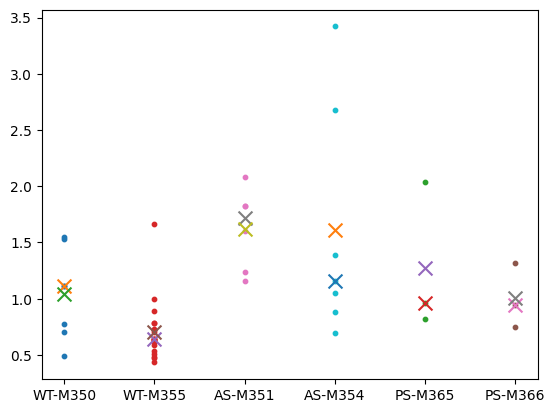

In [ ]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to dcn'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to dcn']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to dcn'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x2d5b97c0a00>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

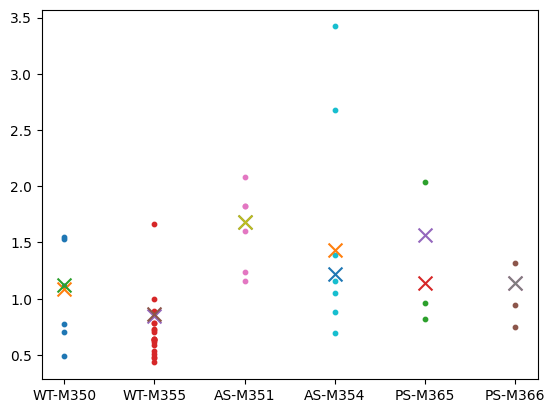

In [ ]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to m1'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to m1']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to m1'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x2d596d77c40>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

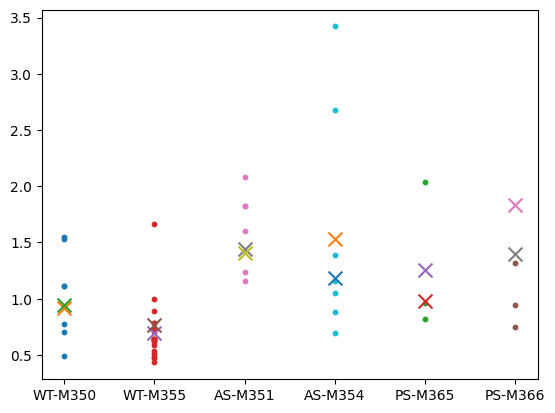

In [ ]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to str'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to str']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to str'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x2d596c809a0>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

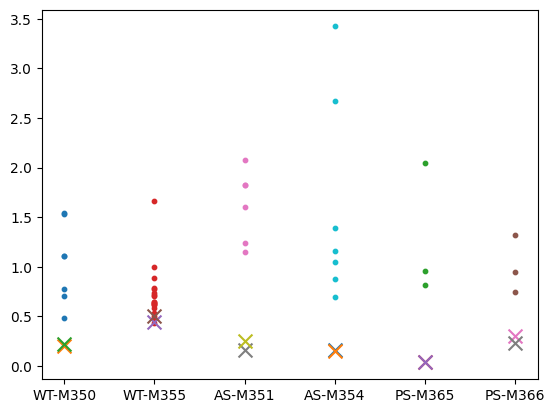

In [ ]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['dcn to dcn'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['dcn to dcn']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['dcn to dcn'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

In [1]:
import matimport statistics

# Using mean and standard deviation (obs: need normal distribution)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.mean(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        plt.plot([i,i], [statistics.mean(current_magn_strengths[animal_model][current])-statistics.stdev(current_magn_strengths[animal_model][current])/2,statistics.mean(current_magn_strengths[animal_model][current])+statistics.stdev(current_magn_strengths[animal_model][current])/2], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')

NameError: name 'plt' is not defined

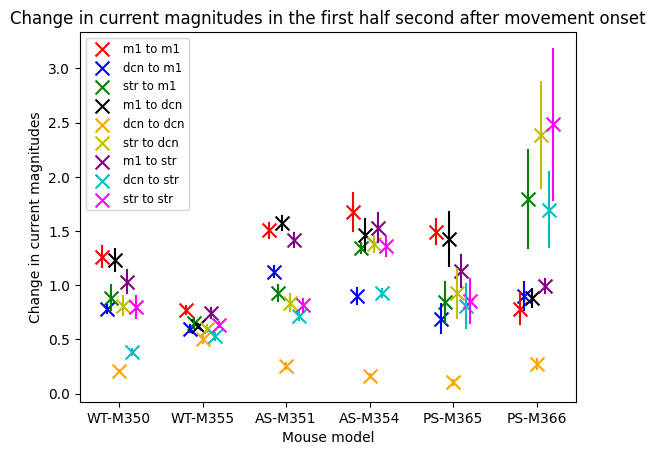

In [20]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.mean(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        plt.plot([i,i], [statistics.mean(current_magn_strengths[animal_model][current])-scipy.stats.sem(current_magn_strengths[animal_model][current])/2,statistics.mean(current_magn_strengths[animal_model][current])+scipy.stats.sem(current_magn_strengths[animal_model][current])/2], color=colors_list[current_index], label=current)
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')

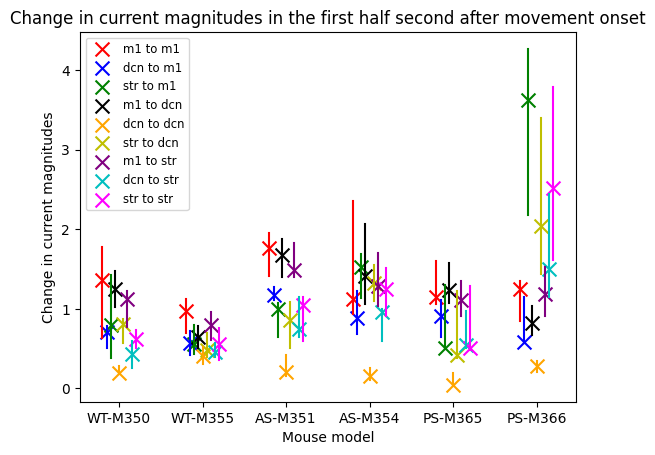

In [ ]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


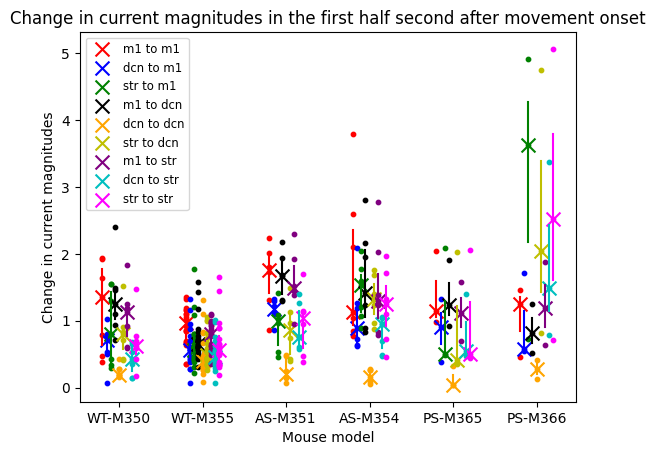

In [ ]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


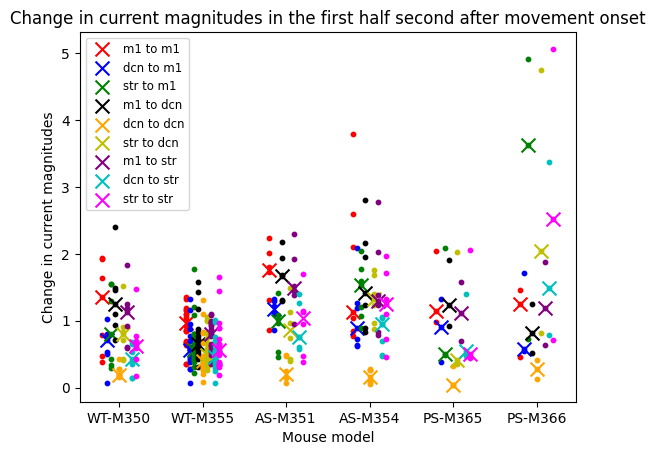

In [ ]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        #plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


In [ ]:
# Decoder from 5D PCA dcn activity to type:

random.shuffle(X_data_dcn_5['WT'])
random.shuffle(X_data_dcn_5['AS'])
random.shuffle(X_data_dcn_5['PS'])

min_samples = min(len(X_data_dcn_5['WT']), len(X_data_dcn_5['AS']), len(X_data_dcn_5['PS']))
X_WT = X_data_dcn_5['WT'][0:min_samples]
X_AS = X_data_dcn_5['AS'][0:min_samples]
X_PS = X_data_dcn_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



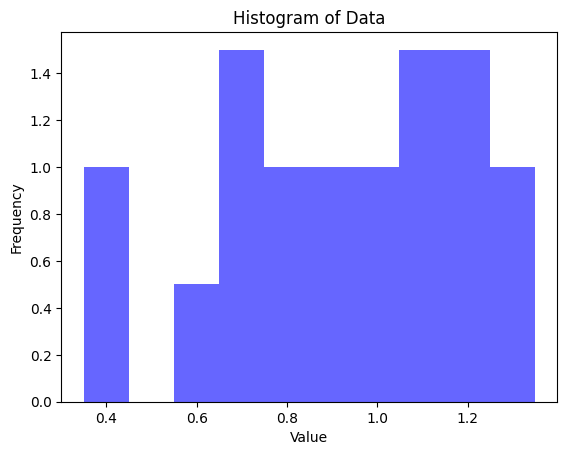

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
data = current_magn_strengths['WT-M355']['m1 to m1']

# Plot histogram
plt.hist(data, density=True, alpha=0.6, color='blue')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

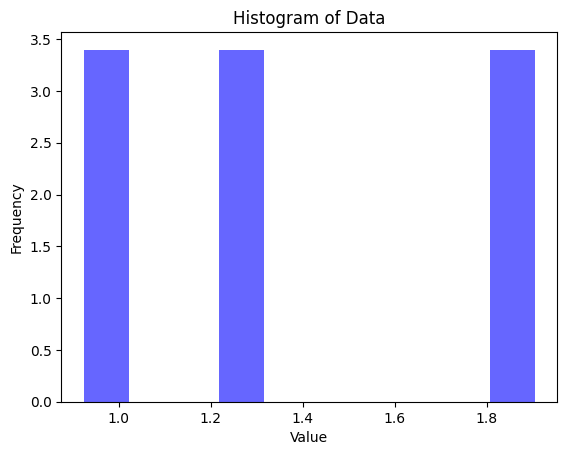

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
data = current_magn_strengths['PS-M365']['m1 to dcn']

# Plot histogram
plt.hist(data, density=True, alpha=0.6, color='blue')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()